In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from __future__ import print_function
import librosa
import numpy as np
import matplotlib.pyplot as plt
from librosa import display,core
from dtw import dtw
from numpy import linalg as LA
from math import sqrt
from scipy import stats
from sklearn import svm
from sklearn.svm import SVR
from mlxtend.plotting import plot_decision_regions
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_predict, cross_val_score,cross_validate
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
#%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler

In [2]:
def accuracy(prediction,actual):
    count=0
    l=len(prediction)
    for i in range(l):
        if(prediction[i]==actual[i]):
            count+=1
    return count/l*100

In [3]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import os

def createTrainingData(start, end):
    samples = []
    telangana_dir = 'audio/Telangana'
    coastal_dir = 'audio/Coastal'
    rayalseema_dir = 'audio/Rayalseema'
    
    regions = {
        'Telangana': telangana_dir,
        'Coastal': coastal_dir,
        'Rayalseema':rayalseema_dir
    }

    for region, region_dir in regions.items():
        if region == 'Telangana':
            file_range = range(239, 357)
        elif region == 'Rayalseema':
            file_range = range(116, 215)
        elif region == 'Coastal':
            file_range = range(1, 102)  # Assuming audio files in Coastal are named from '1.wav' to '101.wav'

        for i in file_range:
            ind = 0
            try:
                file_path = os.path.join(region_dir, f"{i}.wav")
                a, s = librosa.load(file_path)
            except:
                ind = 1

            if ind == 0:
                mfcc = librosa.feature.mfcc(y=a, sr=s)
                temp = mfcc.T[1][start:end]
                for frame in range(10, 50):
                    temp = np.concatenate((temp, mfcc.T[frame][start:end]))
                samples.append([temp, region])

    print(len(samples))
    X = [i[0] for i in samples]
    Y = [j[1] for j in samples]
    return X, Y

data, label = createTrainingData(1, 19)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)


C:\Users\Lavanya Tetakali\AppData\Local\Temp\ipykernel_29316\4124688655.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  a, s = librosa.load(file_path)
C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


317


In [4]:
X_train, X_test, y_train, y_test  = train_test_split(data,label)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Coastal', 93), ('Rayalseema', 93), ('Telangana', 93)]


In [5]:
n_components = 3  # or a higher number
gmm = GaussianMixture(n_components=n_components)

g = GaussianMixture(2)
g.fit(X_resampled)
pred = g.predict(X_test)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on the unique labels in y_test
label_encoder.fit(y_test)

# Transform y_test to numeric labels
y_test_numeric = label_encoder.transform(y_test)

# Now, you can calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_numeric, pred)
conf_matrix

array([[30,  0,  0],
       [24,  1,  0],
       [25,  0,  0]], dtype=int64)

In [7]:
from sklearn.metrics import confusion_matrix

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on the unique labels in y_test
label_encoder.fit(y_test)

# Transform y_test to numeric labels
y_test_numeric = label_encoder.transform(y_test)

# Now, you can calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_numeric, pred)
print(conf_matrix)
# Access the elements of the confusion matrix
tn = conf_matrix[0, 0]  # True negatives
fp = conf_matrix[0, 1]  # False positives
fn = conf_matrix[1, 0]  # False negatives
tp = conf_matrix[1, 1]  # True positives

[[30  0  0]
 [24  1  0]
 [25  0  0]]


In [8]:
precision = round(tp/(tp+fp),4)
recall = round(tp/(tp+fn),4)
fmeasure = round(2*((precision*recall)/(precision+recall)),4)
rej = round(tn/(tn+fp),4)
acc = round((tn+tp)/(tn+tp+fp+fn),4)

In [9]:
accuracy = accuracy(pred,y_test)
print("Accuracy:", accuracy)

print(precision,recall,fmeasure,rej,acc)


Accuracy: 0.0
1.0 0.04 0.0769 1.0 0.5636


C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


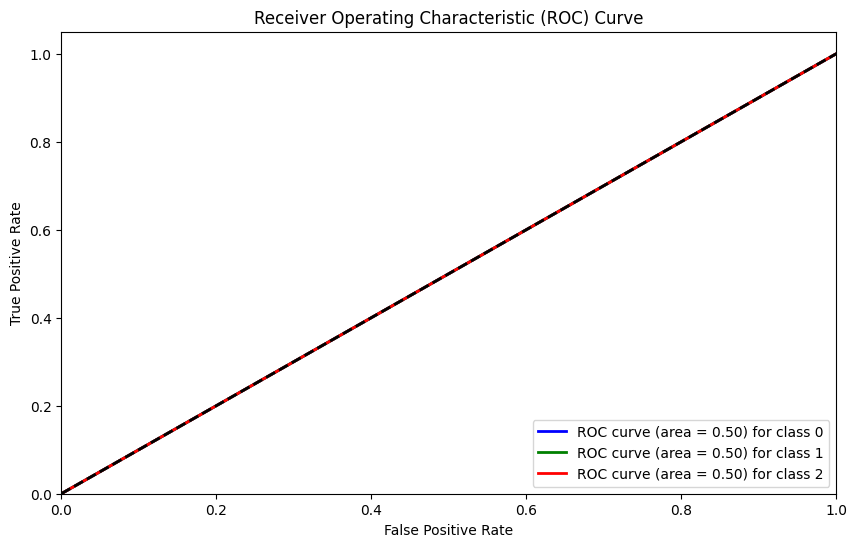

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'pred' contain your actual labels and predicted labels
# Convert labels to binary (0 and 1) for one-vs-all ROC AUC curve
y_test_bin = label_binarize(y_test, classes=['Coastal', 'Rayalseema', 'Telangana'])
pred_bin = label_binarize(pred, classes=['Coastal', 'Rayalseema', 'Telangana'])

n_classes = y_test_bin.shape[1]

# Initialize variables to store the ROC curve and AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC AUC curves
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [11]:
print("Unique Predicted Classes:", np.unique(pred))


Unique Predicted Classes: [0 1]


In [12]:
# Check for Predicted Classes
print("Unique Predicted Classes:", np.unique(pred))

# Check for Label Encoding
print("Unique Classes in y_test:", np.unique(y_test))

# Check for Class Imbalance
print("Class Distribution in y_test:", Counter(y_test))
print("Class Distribution in pred:", Counter(pred))

# Check for Data Quality
# Optionally, inspect a few samples in X_test and y_test to ensure data integrity.



Unique Predicted Classes: [0 1]
Unique Classes in y_test: ['Coastal' 'Rayalseema' 'Telangana']
Class Distribution in y_test: Counter({'Coastal': 30, 'Telangana': 25, 'Rayalseema': 25})
Class Distribution in pred: Counter({0: 79, 1: 1})


In [13]:
print("Shape of X_train:", np.shape(X_train))
print("Shape of y_train:", np.shape(y_train))


Shape of X_train: (237, 738)
Shape of y_train: (237,)


In [15]:
from sklearn.metrics import classification_report

# Assuming 'y_test' contains the true labels and 'pred' contains the predicted labels
report = classification_report(y_test, pred)

# Print the classification report
print(report)


ValueError: Mix of label input types (string and number)

In [16]:
# Convert numeric labels in pred back to string labels
pred_labels = label_encoder.inverse_transform(pred)

# Now you can generate the classification report
report = classification_report(y_test, pred_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Coastal       0.38      1.00      0.55        30
  Rayalseema       1.00      0.04      0.08        25
   Telangana       0.00      0.00      0.00        25

    accuracy                           0.39        80
   macro avg       0.46      0.35      0.21        80
weighted avg       0.45      0.39      0.23        80



C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 